In [272]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,hamming_loss
import math
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,Dataset,TensorDataset
from PIL import Image
import random

### Loading train,test and val sets and visualizing

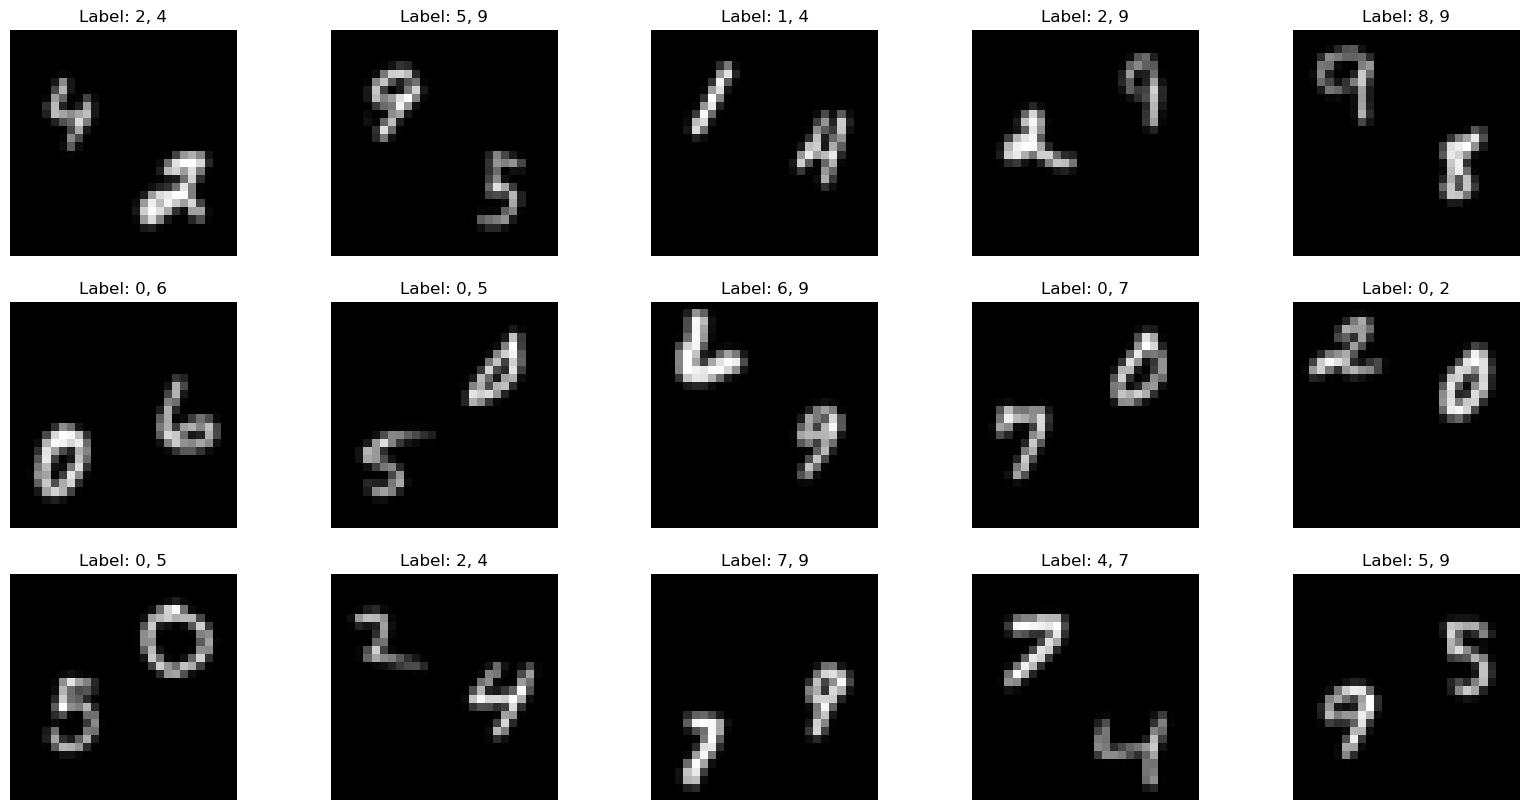

In [273]:
data_folder = './doublemnist'
digits = list(map(str, range(10)))
image_data = []
labels = []
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])
img_dt_val=[]
labels_val=[]
img_dt_test=[]
labels_test=[]

for a in digits:
    for b in digits:
        if a != b:
            source_folder = os.path.join(data_folder, 'train', f'{a}{b}')
            src_folder_val=os.path.join(data_folder, 'val', f'{a}{b}')
            src_folder_test=os.path.join(data_folder, 'test', f'{a}{b}')
            if os.path.exists(src_folder_val):
                image_files = [f for f in os.listdir(src_folder_val) if f.endswith('.png')]
                for image_file in image_files:
                    image_path = os.path.join(src_folder_val, image_file)
                    image = Image.open(image_path)
                    image = transform(image)
                    img_dt_val.append(image)
                    label = torch.zeros(10)
                    label[int(a)] = 1
                    label[int(b)] = 1
                    labels_val.append(label)
            if os.path.exists(src_folder_test):
                image_files = [f for f in os.listdir(src_folder_test) if f.endswith('.png')]
                for image_file in image_files:
                    image_path = os.path.join(src_folder_test, image_file)
                    image = Image.open(image_path)
                    image = transform(image)
                    img_dt_test.append(image)
                    label = torch.zeros(10)
                    label[int(a)] = 1
                    label[int(b)] = 1
                    labels_test.append(label)
            if os.path.exists(source_folder):
                image_files = [f for f in os.listdir(source_folder) if f.endswith('.png')]
                for image_file in image_files:
                    image_path = os.path.join(source_folder, image_file)
                    image = Image.open(image_path)
                    image = transform(image)
                    image_data.append(image)
                    label = torch.zeros(10)
                    label[int(a)] = 1
                    label[int(b)] = 1
                    labels.append(label)
x_train = torch.stack(image_data, dim=0)
y_train = torch.stack(labels, dim=0)
x_val=torch.stack(img_dt_val, dim=0)
y_val=torch.stack(labels_val, dim=0)
x_test=torch.stack(img_dt_test, dim=0)
y_test=torch.stack(labels_test, dim=0)
# test 18000,val 14000, train 58000, y's onehot 10 
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
random_integers = [random.randint(0, x_train.size(0) - 1) for _ in range(15)]
j=0
k=0
for i in random_integers:
    image = x_train[i].numpy().reshape(28, 28)
    label = y_train[i]
    indices = torch.nonzero(label).squeeze()
    digits = [str(index.item()) for index in indices]
    label_string = ', '.join(digits)
    axes[k][j].imshow(image, cmap='gray')
    axes[k][j].set_title(f'Label: {label_string}')
    axes[k][j].axis('off')
    j+=1
    if j==5:
        j=0
        k+=1
plt.show()

### MLP on MultiMNIST

In [277]:
class MLPModel(nn.Module):
    def __init__(self,l_rate,batch_size):
        super(MLPModel, self).__init__()
        self.learning_rate=l_rate
        self.batch_size=batch_size
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.out=nn.Linear(64,10)
        self.softmax=nn.LogSoftmax(dim=1)
        self.optimizer = optim.Adam(self.parameters(), lr=l_rate)
        self.criterion = nn.CrossEntropyLoss()
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.out(x)
        x = self.softmax(x)
        return x
    def train(self,train_dataset,val_dataset,num_epochs):
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=True)
        for epoch in range(num_epochs):
            for images, labels in train_loader:
                self.optimizer.zero_grad()
                output = self.forward(images)
                loss = self.criterion(output, labels)
                loss.backward()
                self.optimizer.step()
            # Validation loop
            pred=torch.empty(0)
            orig=torch.empty(0)
            for images, labels in val_loader:
                output = self.forward(images)
                result_tensor = torch.stack([torch.zeros(10).scatter_(0, torch.topk(row, k=2).indices, 1) for row in output])
                orig=torch.cat((orig,labels),dim=0)
                pred=torch.cat((pred,result_tensor),dim=0)
            hamming_distance = (pred != orig).float()
            mean_hamming_loss = hamming_distance.mean()
            print(f'Epoch [{epoch+1}/{num_epochs}] - Validation Accuracy (using mean hamming loss): {100*(1-mean_hamming_loss)}%')
    def eval(self,test_dataset):
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=True)
        pred=torch.empty(0)
        orig=torch.empty(0)
        for images, labels in test_loader:
            output = self.forward(images)
            result_tensor = torch.stack([torch.zeros(10).scatter_(0, torch.topk(row, k=2).indices, 1) for row in output])
            orig=torch.cat((orig,labels),dim=0)
            pred=torch.cat((pred,result_tensor),dim=0)
        hamming_distance = (pred != orig).float()
        mean_hamming_loss = hamming_distance.mean()
        print(f'Test Accuracy (using hamming loss): {100*(1-mean_hamming_loss)}%')
        return pred

In [279]:
train_dataset = TensorDataset(x_train, y_train)
val_dataset=TensorDataset(x_val,y_val)
test_dataset=TensorDataset(x_test,y_test)

model = MLPModel(0.0001,64)
model.train(train_dataset,val_dataset,15)
out=model.eval(test_dataset)

Epoch [1/15] - Validation Accuracy (using mean hamming loss): 73.00285339355469%
Epoch [2/15] - Validation Accuracy (using mean hamming loss): 74.644287109375%
Epoch [3/15] - Validation Accuracy (using mean hamming loss): 75.95000457763672%
Epoch [4/15] - Validation Accuracy (using mean hamming loss): 76.43142700195312%
Epoch [5/15] - Validation Accuracy (using mean hamming loss): 77.58856964111328%
Epoch [6/15] - Validation Accuracy (using mean hamming loss): 78.0857162475586%
Epoch [7/15] - Validation Accuracy (using mean hamming loss): 78.88713836669922%
Epoch [8/15] - Validation Accuracy (using mean hamming loss): 79.7357177734375%
Epoch [9/15] - Validation Accuracy (using mean hamming loss): 79.83428192138672%
Epoch [10/15] - Validation Accuracy (using mean hamming loss): 80.03713989257812%
Epoch [11/15] - Validation Accuracy (using mean hamming loss): 80.44285583496094%
Epoch [12/15] - Validation Accuracy (using mean hamming loss): 80.94429016113281%
Epoch [13/15] - Validation Ac

### CNN on MultiMNIST

In [274]:
class CNNModel(nn.Module):
    def __init__(self,l_rate,batch_size):
        super(CNNModel, self).__init__()
        self.learning_rate=l_rate
        self.batch_size=batch_size
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        # we have 32 filters for layer conv1 so we will get 32 different outputs which will extract different features
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # 64 kernels
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.25)
        self.fc = nn.Linear(64 * 7 * 7, 10)  # 10 output classes for MNIST
        self.softmax = nn.LogSoftmax(dim=1)
        self.optimizer = optim.Adam(self.parameters(), lr=l_rate)
        self.criterion = nn.CrossEntropyLoss()
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        x = self.softmax(x)
        return x
    def train(self,train_dataset,val_dataset,num_epochs):
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=True)
        for epoch in range(num_epochs):
            for images, labels in train_loader:
                self.optimizer.zero_grad()
                output = self.forward(images)
                loss = self.criterion(output, labels)
                loss.backward()
                self.optimizer.step()
            # Validation loop
            pred=torch.empty(0)
            orig=torch.empty(0)
            for images, labels in val_loader:
                output = self.forward(images)
                result_tensor = torch.stack([torch.zeros(10).scatter_(0, torch.topk(row, k=2).indices, 1) for row in output])
                orig=torch.cat((orig,labels),dim=0)
                pred=torch.cat((pred,result_tensor),dim=0)
            hamming_distance = (pred != orig).float()
            mean_hamming_loss = hamming_distance.mean()
            print(f'Epoch [{epoch+1}/{num_epochs}] - Validation Accuracy (using mean hamming loss): {100*(1-mean_hamming_loss)}%')
    def eval(self,test_dataset):
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=True)
        pred=torch.empty(0)
        orig=torch.empty(0)
        for images, labels in test_loader:
            output = self.forward(images)
            result_tensor = torch.stack([torch.zeros(10).scatter_(0, torch.topk(row, k=2).indices, 1) for row in output])
            orig=torch.cat((orig,labels),dim=0)
            pred=torch.cat((pred,result_tensor),dim=0)
        hamming_distance = (pred != orig).float()
        mean_hamming_loss = hamming_distance.mean()
        print(f'Test Accuracy (using hamming loss): {100*(1-mean_hamming_loss)}%')
        return pred

In [275]:
train_dataset = TensorDataset(x_train, y_train)
val_dataset=TensorDataset(x_val,y_val)
test_dataset=TensorDataset(x_test,y_test)

model = CNNModel(0.0001,64)
model.train(train_dataset,val_dataset,15)
out=model.eval(test_dataset)

Epoch [1/15] - Validation Accuracy (using mean hamming loss): 75.1914291381836%
Epoch [2/15] - Validation Accuracy (using mean hamming loss): 79.3614273071289%
Epoch [3/15] - Validation Accuracy (using mean hamming loss): 81.45999908447266%
Epoch [4/15] - Validation Accuracy (using mean hamming loss): 82.54142761230469%
Epoch [5/15] - Validation Accuracy (using mean hamming loss): 83.80714416503906%
Epoch [6/15] - Validation Accuracy (using mean hamming loss): 84.9528579711914%
Epoch [7/15] - Validation Accuracy (using mean hamming loss): 85.81428527832031%
Epoch [8/15] - Validation Accuracy (using mean hamming loss): 85.79142761230469%
Epoch [9/15] - Validation Accuracy (using mean hamming loss): 86.52428436279297%
Epoch [10/15] - Validation Accuracy (using mean hamming loss): 86.58285522460938%
Epoch [11/15] - Validation Accuracy (using mean hamming loss): 86.97999572753906%
Epoch [12/15] - Validation Accuracy (using mean hamming loss): 87.16000366210938%
Epoch [13/15] - Validation A

### Testing trained Multi-MNIST mondel on single digit MNIST dataset

In [276]:
test_dataset = datasets.MNIST(root='./data', train=False, download=True)
imgs=test_dataset.data/255
imgs=imgs.unsqueeze(1)
labs=test_dataset.targets
labs = (torch.nn.functional.one_hot(labs, 10)).float()
new_testset=TensorDataset(imgs,labs)
out=model.eval(new_testset)

Test Accuracy (using hamming loss): 72.58200073242188%


### MLP for Permuted MNIST

In [280]:
data = np.load("permuted_mnist.npz")
x_train=data['train_images']/255
y_train=data['train_labels']
x_test=data['test_images']/255
y_test=data['test_labels']
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
x_train=torch.tensor(x_train,dtype=torch.float)
x_test=torch.tensor(x_test,dtype=torch.float)
x_val=torch.tensor(x_val,dtype=torch.float)
y_train=torch.tensor(y_train)
y_test=torch.tensor(y_test)
y_val=torch.tensor(y_val)
x_train=x_train.unsqueeze(1)
x_test=x_test.unsqueeze(1)
x_val=x_val.unsqueeze(1)

In [281]:
class MLPmodel(nn.Module):
    def __init__(self,l_rate,batch_size):
        super(MLPmodel, self).__init__()
        self.learning_rate=l_rate
        self.batch_size=batch_size
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.out=nn.Linear(64,10)
        self.softmax=nn.LogSoftmax(dim=1)
        self.optimizer = optim.Adam(self.parameters(), lr=l_rate)
        self.criterion = nn.CrossEntropyLoss()
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.out(x)
        x = self.softmax(x)
        return x
    def train(self,train_dataset,val_dataset,num_epochs):
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=False)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        for epoch in range(num_epochs):
            for images, labels in train_loader:
                self.optimizer.zero_grad()
                output = self.forward(images)
                loss = self.criterion(output, labels)
                loss.backward()
                self.optimizer.step()
            # Validation loop
            correct = 0
            total = 0
            for images, labels in val_loader:
                output = self.forward(images)
                _, predicted = torch.max(output.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            val_accuracy = 100 * correct / total
            total=0
            correct=0
            for images, labels in train_loader:
                output = self.forward(images)
                _, predicted = torch.max(output.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            train_accuracy = 100 * correct / total
            print(f'Epoch [{epoch+1}/{num_epochs}] - Validation Accuracy: {val_accuracy:.2f}%, Training Accuracy: {train_accuracy:.2f}%')
    def eval(self,test_dataset):
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)
        test_correct = 0
        test_total = 0
        pred=torch.empty(0)
        for images, labels in test_loader:
            output = self.forward(images)
            _, predicted = torch.max(output.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            pred=torch.cat((pred,predicted),dim=0)
        test_accuracy = 100 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy:.2f}%')
        return pred

In [282]:
train_dataset = TensorDataset(x_train, y_train)
val_dataset=TensorDataset(x_val,y_val)
test_dataset=TensorDataset(x_test,y_test)

model = MLPmodel(0.0001,64)
model.train(train_dataset,val_dataset,25)
out=model.eval(test_dataset)

Epoch [1/25] - Validation Accuracy: 89.93%, Training Accuracy: 89.60%
Epoch [2/25] - Validation Accuracy: 91.93%, Training Accuracy: 92.01%
Epoch [3/25] - Validation Accuracy: 93.18%, Training Accuracy: 93.26%
Epoch [4/25] - Validation Accuracy: 94.05%, Training Accuracy: 94.20%
Epoch [5/25] - Validation Accuracy: 94.67%, Training Accuracy: 94.88%
Epoch [6/25] - Validation Accuracy: 95.22%, Training Accuracy: 95.48%
Epoch [7/25] - Validation Accuracy: 95.70%, Training Accuracy: 96.03%
Epoch [8/25] - Validation Accuracy: 96.13%, Training Accuracy: 96.42%
Epoch [9/25] - Validation Accuracy: 96.42%, Training Accuracy: 96.79%
Epoch [10/25] - Validation Accuracy: 96.62%, Training Accuracy: 97.15%
Epoch [11/25] - Validation Accuracy: 96.83%, Training Accuracy: 97.42%
Epoch [12/25] - Validation Accuracy: 96.97%, Training Accuracy: 97.64%
Epoch [13/25] - Validation Accuracy: 97.10%, Training Accuracy: 97.83%
Epoch [14/25] - Validation Accuracy: 97.23%, Training Accuracy: 98.02%
Epoch [15/25] -

### CNN for Permuted MNIST

In [283]:
data = np.load("permuted_mnist.npz")
x_train=data['train_images']/255
y_train=data['train_labels']
x_test=data['test_images']/255
y_test=data['test_labels']
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
x_train=torch.tensor(x_train,dtype=torch.float)
x_test=torch.tensor(x_test,dtype=torch.float)
x_val=torch.tensor(x_val,dtype=torch.float)
y_train=torch.tensor(y_train)
y_test=torch.tensor(y_test)
y_val=torch.tensor(y_val)
x_train=x_train.unsqueeze(1)
x_test=x_test.unsqueeze(1)
x_val=x_val.unsqueeze(1)

In [284]:
class CNNmodel(nn.Module):
    def __init__(self,l_rate,batch_size):
        super(CNNmodel, self).__init__()
        self.learning_rate=l_rate
        self.batch_size=batch_size
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        # we have 32 filters for layer conv1 so we will get 32 different outputs which will extract different features
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # 64 kernels
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.25)
        self.fc = nn.Linear(64 * 7 * 7, 10)  # 10 output classes for MNIST
        self.softmax = nn.LogSoftmax(dim=1)
        self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        self.criterion = nn.CrossEntropyLoss()
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        x = self.softmax(x)
        return x
    def train(self,train_dataset,val_dataset,num_epochs):
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=False)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        for epoch in range(num_epochs):
            for images, labels in train_loader:
                self.optimizer.zero_grad()
                output = self.forward(images)
                loss = self.criterion(output, labels)
                loss.backward()
                self.optimizer.step()
            # Validation loop
            correct = 0
            total = 0
            for images, labels in val_loader:
                output = self.forward(images)
                _, predicted = torch.max(output.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            val_accuracy = 100 * correct / total
            total=0
            correct=0
            for images, labels in train_loader:
                output = self.forward(images)
                _, predicted = torch.max(output.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            train_accuracy = 100 * correct / total
            print(f'Epoch [{epoch+1}/{num_epochs}] - Validation Accuracy: {val_accuracy:.2f}%, Training Accuracy: {train_accuracy:.2f}%')
    def eval(self,test_dataset):
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)
        test_correct = 0
        test_total = 0
        pred=torch.empty(0)
        for images, labels in test_loader:
            output = self.forward(images)
            _, predicted = torch.max(output.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            pred=torch.cat((pred,predicted),dim=0)
        test_accuracy = 100 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy:.2f}%')
        return pred

In [285]:
train_dataset = TensorDataset(x_train, y_train)
val_dataset=TensorDataset(x_val,y_val)
test_dataset=TensorDataset(x_test,y_test)

model = CNNmodel(0.0001,64)
model.train(train_dataset,val_dataset,10)
out=model.eval(test_dataset)

Epoch [1/10] - Validation Accuracy: 82.33%, Training Accuracy: 82.47%
Epoch [2/10] - Validation Accuracy: 86.20%, Training Accuracy: 86.78%
Epoch [3/10] - Validation Accuracy: 88.85%, Training Accuracy: 88.65%
Epoch [4/10] - Validation Accuracy: 89.92%, Training Accuracy: 90.03%
Epoch [5/10] - Validation Accuracy: 90.78%, Training Accuracy: 91.11%
Epoch [6/10] - Validation Accuracy: 91.67%, Training Accuracy: 91.85%
Epoch [7/10] - Validation Accuracy: 92.08%, Training Accuracy: 92.46%
Epoch [8/10] - Validation Accuracy: 92.62%, Training Accuracy: 93.07%
Epoch [9/10] - Validation Accuracy: 93.08%, Training Accuracy: 93.50%
Epoch [10/10] - Validation Accuracy: 93.22%, Training Accuracy: 93.70%
Test Accuracy: 93.43%


#### For the MultiMNIST dataset, the MLP model performs well but not as good as the CNN model because CNNs excel at capturing spatial relationships and hierarchical features, making them suitable for tasks like multi-digit recognition.They can automatically learn to extract features and relationships between digits in the image. MLPs, in contrast, do not have built-in spatial awareness and may struggle to learn the necessary relationships between the digits in multiMNIST. Whereas, for the permuted MNIST dataset, MLPs perform better than CNNs. By randomizing image pixels the hierarchical structure of the data is destroyed and long range correlations are introduced which standard CNNs are not able to capture.

### [Reference](https://openaccess.thecvf.com/content_CVPRW_2019/papers/Deep%20Vision%20Workshop/Ivan_Convolutional_Neural_Networks_on_Randomized_Data_CVPRW_2019_paper.pdf)